In [1]:
from helpers.warp import *
from detection_to_fen import *
import chess
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import torch

running cuda...


In [2]:
device = "cpu"
if torch.cuda.is_available():
    print('running cuda...')
    device = "cuda"
elif torch.backends.mps.is_available():
    print('running mps...')
    device = "mps"

running cuda...


In [3]:
from dataloader import PieceDetectorDataset, BoardDetectorDataset
img_size = 600
piece_dataset = PieceDetectorDataset(root='dataloader/data/data_generation/val',
                                     json_file='dataloader/data/data_generation/val/piece_coco.json',
                                     size=(img_size, img_size))
board_dataset = BoardDetectorDataset(root='dataloader/data/data_generation/val',
                                     json_file='dataloader/data/data_generation/val/board_coco.json',
                                     target='points',
                                     size=img_size)
board_dataset_mask = BoardDetectorDataset(root='dataloader/data/data_generation/val',
                                          json_file='dataloader/data/data_generation/val/board_coco.json',
                                          target='mask',
                                          size=img_size)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Piece Detector Dataset initialized!
Board Detector Dataset initalized!
Board Detector Dataset initalized!


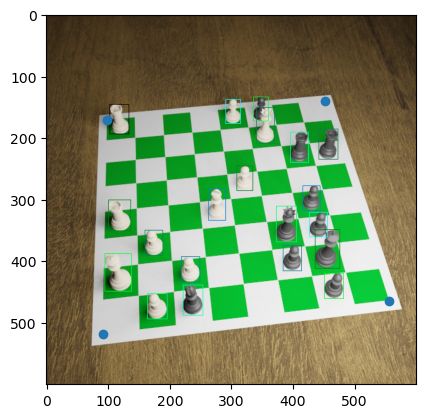

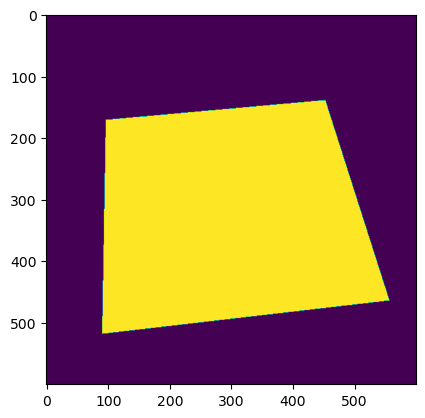

In [4]:
idx = 8
img, target = piece_dataset[idx]
_, coords = board_dataset[idx]
coords *= img_size
_, mask = board_dataset_mask[idx]
img = (img * 255).to(torch.uint8)
bbox_img = draw_bounding_boxes(img, target['boxes'])
plt.imshow(bbox_img.detach().cpu().permute(1, 2, 0))
plt.scatter(coords[0::2], coords[1::2])
plt.show()
plt.imshow(mask[0].detach().cpu())
plt.show()

In [7]:
img, bboxes, labels, coords = get_predictions(f'dataloader/data/data_generation/images/{idx + 1}.jpg',
                                              piece_weight='models/checkpoints/piece_detector/600_faster_rcnn/final/synthetic_weight_2_0.01',
                                              board_weight='models/checkpoints/board_detector/resnet/weight_16_0.0001',
                                              img_size=img_size,
                                              threshold=0.5)
_, real_bboxes, real_labels, real_coords = get_actual(idx, piece_dataset=piece_dataset, board_dataset=board_dataset, img_size=img_size)
points = bboxes_to_points(bboxes, offset=1.5)
real_points = bboxes_to_points(real_bboxes, offset=1.5)
warped_img, M = warp(img, reshape_coords(real_coords), device=device)
warped_points = transform_points(M, points)
real_warped_points = transform_points(M, real_points)
fen = calculateFEN(warped_points[0], labels, img_size)
real_fen = calculateFEN(real_warped_points[0], real_labels, img_size)

Model initialized!


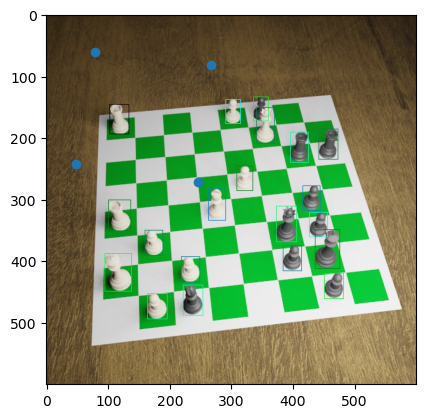

In [8]:
plt.imshow(bbox_img.detach().cpu().permute(1, 2, 0))
coords = coords.detach().cpu()
plt.scatter(coords[0::2], coords[1::2])
plt.show()

Model initialized!


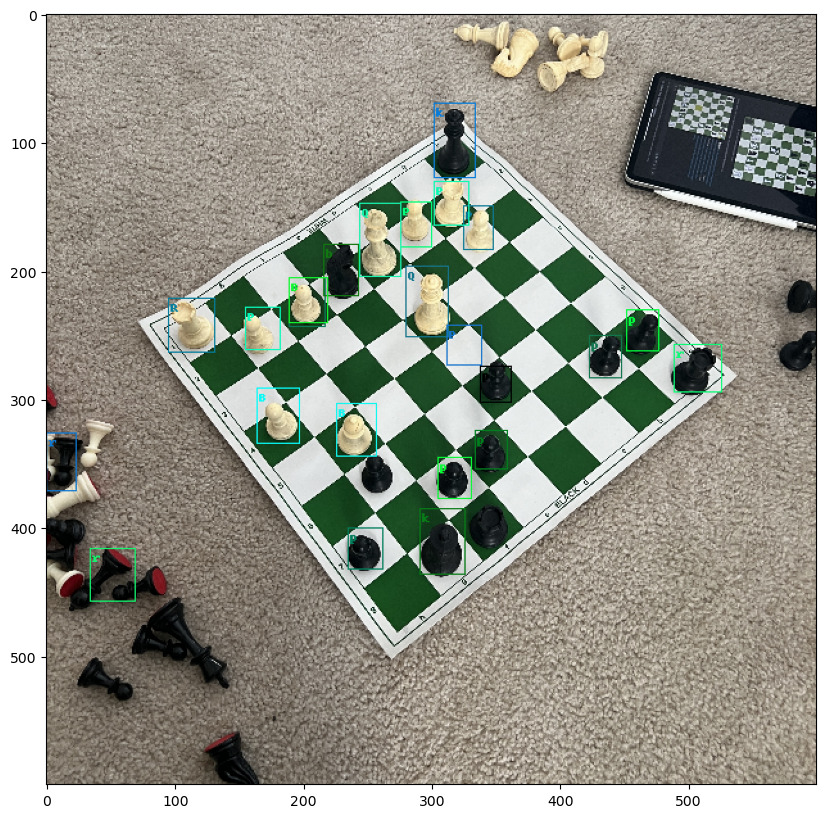

In [15]:
img, bboxes, labels, coords = get_predictions(f'dataloader/data/raw/IMG_0628.jpg',
                                              piece_weight='models/checkpoints/piece_detector/600_faster_rcnn/final/synthetic_weight_2_0.01',
                                              img_size=img_size,
                                              threshold=0.7)
bboxes_img = draw_bounding_boxes(img[0].to(torch.uint8), bboxes, labels)
plt.figure(figsize=(10, 10))
plt.imshow(bboxes_img.cpu().permute(1, 2, 0))
plt.show()

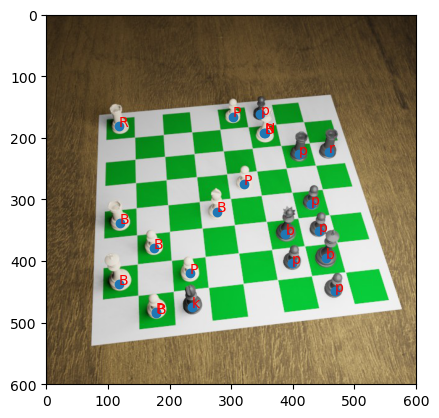

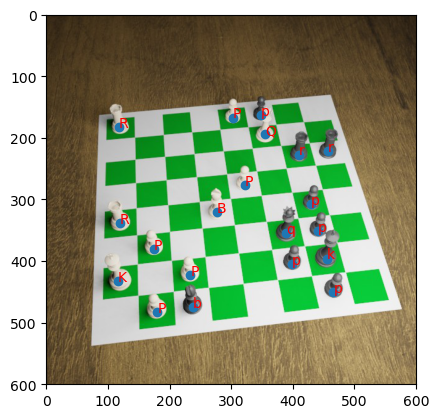

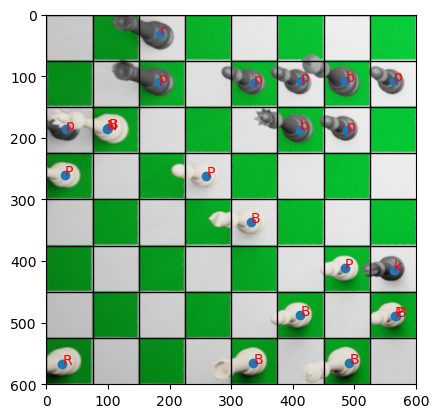

In [11]:
warped_out = warped_points.transpose(1, 2)[0]
out = points.transpose(1, 2)[0]

real_out = real_points.transpose(1, 2)[0]

plt.imshow(img[0].to('cpu').to(torch.uint8).permute(1, 2, 0))
plt.scatter(out[0].detach().to('cpu'), out[1].detach().to('cpu'))
for i, label in enumerate(labels):
    plt.annotate(label, (out[0][i], out[1][i]), color='red')
plt.xlim([0, img_size])
plt.ylim([img_size, 0])
plt.show()

plt.imshow(img[0].to('cpu').to(torch.uint8).permute(1, 2, 0))
plt.scatter(real_out[0].detach().to('cpu'), real_out[1].detach().to('cpu'))
for i, label in enumerate(real_labels):
    plt.annotate(label, (real_out[0][i], real_out[1][i]), color='red')
plt.xlim([0, img_size])
plt.ylim([img_size, 0])
plt.show()

plt.imshow(warped_img[0].to('cpu').to(torch.uint8).permute(1, 2, 0))
plt.scatter(warped_out[0].detach().to('cpu'), warped_out[1].detach().to('cpu'))
for i, label in enumerate(labels):
    plt.annotate(label, (warped_out[0][i], warped_out[1][i]), color='red')
for i in range(8):
    plt.axhline(y=i * (img_size // 8), color='black', linewidth=1)
    plt.axvline(x=i * (img_size // 8), color='black', linewidth=1)
plt.xlim([0, img_size])
plt.ylim([img_size, 0])
plt.show()

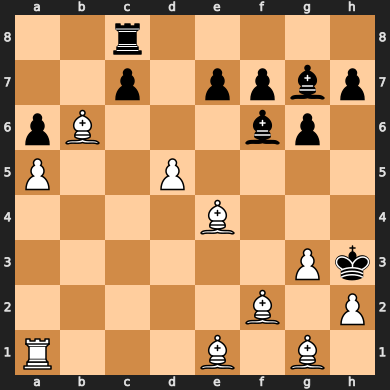

In [12]:
chess.Board(fen)

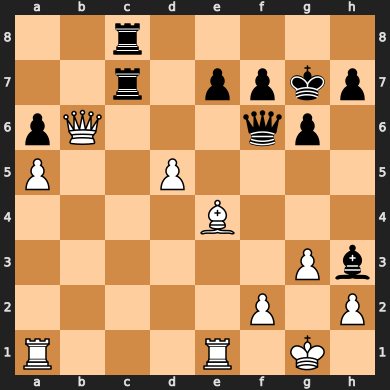

In [13]:
chess.Board(real_fen)